In [15]:
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg
import mediapy as media
import matplotlib.pyplot as plt
import mujoco

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [16]:
with open("humanoid.xml") as f:
    xml = f.read()

In [17]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

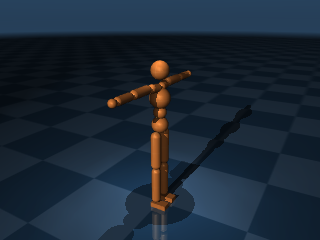

In [18]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

""

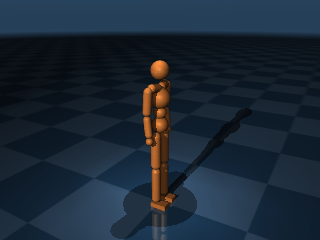

In [19]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [21]:
import os, shutil

# `which ffmpeg` location
ffmpeg_dir = "/opt/homebrew/bin"

if ffmpeg_dir not in os.environ.get("PATH", ""):
    os.environ["PATH"] += os.pathsep + ffmpeg_dir

print("New PATH:", os.environ["PATH"])
print("ffmpeg now at:", shutil.which("ffmpeg"))


New PATH: /Users/vihaan/Projects/backflip/.venv/bin:/Users/vihaan/.juliaup/bin:/Users/vihaan/.cargo/bin:/Users/vihaan/.local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/bin:/opt/homebrew/bin
ffmpeg now at: /opt/homebrew/bin/ffmpeg


In [40]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

In [41]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 0)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('pelvis').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [42]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[   0.       0.      -7.518    0.072   23.515   -0.       0.072    1.966    0.       0.       0.
    0.     621.005 -124.353  -32.149   72.545 -620.933  124.357   32.246  -72.518    0.      10.775
    0.      10.775    0.      10.775    0.       0.      10.775   -0.      10.775    0.      10.775
   -0.   ]


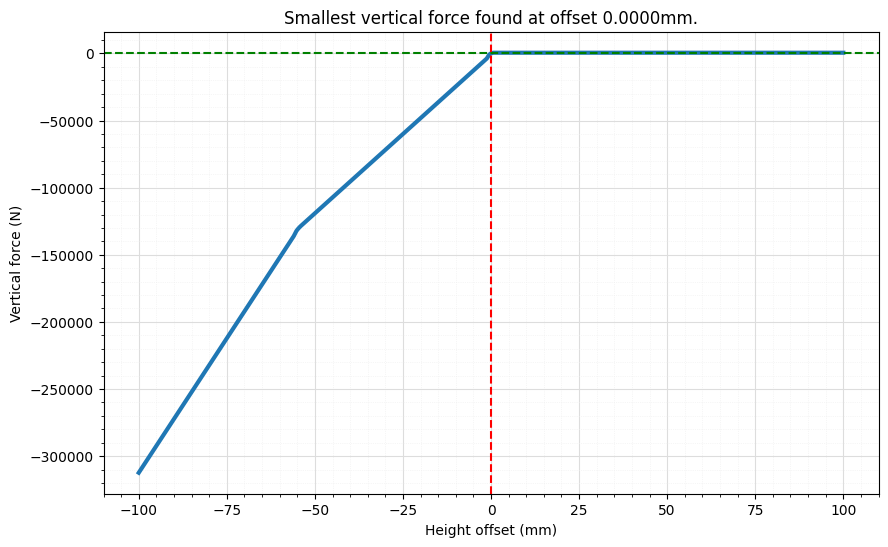

In [43]:
height_offsets = np.linspace(-0.1, 0.1, 10001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

In [44]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
print(data.qpos[2])
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

0.880749
desired forces: [   0.       0.      -7.518    0.072   23.515   -0.       0.072    1.966    0.       0.       0.
    0.     621.005 -124.353  -32.149   72.545 -620.933  124.357   32.246  -72.518    0.      10.775
    0.      10.775    0.      10.775    0.       0.      10.775   -0.      10.775    0.      10.775
   -0.   ]


In [45]:
actuator_moment = np.zeros((model.nu, model.nv))
mujoco.mju_sparse2dense(
    actuator_moment,
    data.actuator_moment.reshape(-1),
    data.moment_rownnz,
    data.moment_rowadr,
    data.moment_colind.reshape(-1),
)
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [ 0.     0.01   0.     0.     0.     0.     6.21  -1.244 -0.321  1.036 -6.209  1.244  0.322 -1.036
  0.     0.     0.054  0.072  0.     0.12   0.     0.    -0.     0.054  0.072  0.     0.12  -0.   ]


In [46]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [   0.       0.       0.       0.       0.       0.       0.072    1.966    0.       0.       0.
    0.     100.    -100.     -32.149   70.    -100.     100.      32.246  -70.       0.      10.775
    0.      10.775    0.      10.775    0.       0.      10.775   -0.      10.775    0.      10.775
   -0.   ]


In [47]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('pelvis').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [48]:
nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)

In [49]:
nv = model.nv  # Shortcut for the number of DoFs.

# Get the Jacobian for the root body (torso) CoM.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
mujoco.mj_forward(model, data)
jac_com = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('torso').id)

# Get the Jacobian for the left foot.
jac_foot = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('left_foot').id)

jac_diff = jac_com - jac_foot
Qbalance = jac_diff.T @ jac_diff

In [50]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
root_dofs = range(6)
body_dofs = range(6, nv)
abdomen_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'abdomen' in name
    and not 'z' in name
]
left_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'left' in name
    and ('hip' in name or 'knee' in name or 'ankle' in name)
    and not 'z' in name
]
balance_dofs = abdomen_dofs + left_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

In [51]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(nv)
Qjoint[root_dofs, root_dofs] *= 0  # Don't penalize free joint directly.
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

In [52]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

In [53]:
# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

In [54]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [55]:
data.qpos

array([-0.008, -0.007,  0.881,  1.   , -0.   ,  0.001, -0.003, -0.028,  0.011, -0.002, -0.062,
        0.018, -0.   ,  0.271, -0.249, -0.013,  0.231, -0.271,  0.248,  0.142, -0.235,  0.009,
       -0.01 ,  0.005, -0.002, -0.008,  0.007,  0.002,  0.008, -0.007,  0.006, -0.005, -0.006,
        0.008,  0.002])

In [56]:
# Parameters.
DURATION = 12         # seconds
FRAMERATE = 60        # Hz
TOTAL_ROTATION = 15   # degrees
CTRL_RATE = 0.8       # seconds
BALANCE_STD = 0.01    # actuator units
OTHER_STD = 0.08      # actuator units

# Make new camera, set distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# Set the scale of visualized contact forces to 1cm/N.
model.vis.map.force = 0.01

# Define smooth orbiting function.
def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time*2*np.pi)
def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time/DURATION) * TOTAL_ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION/model.opt.timestep))
perturb = np.random.randn(nsteps, nu)

# Scaling vector with different STD for "balance" and "other"
CTRL_STD = np.empty(nu)
for i in range(nu):
  joint = model.actuator(i).trnid[0]
  dof = model.joint(joint).dofadr[0]
  CTRL_STD[i] = BALANCE_STD if dof in balance_dofs else OTHER_STD

# Smooth the noise.
width = int(nsteps * CTRL_RATE/DURATION)
kernel = np.exp(-0.5*np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(model, width=1280, height=720)

frames = []
step = 0
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Add perturbation, increment step.
  data.ctrl += CTRL_STD * perturb[step]
  step += 1

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera, scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)